### Socio-enviornmental analysis of Vegetation coverage of Philadelphia

In this tutorial, we will try to answer an important question, where are tree canopies in Philadelphia? 

We will use Python to analyze the land cover map of Philadelphia, create tree canopy cover map at census tract level,  analyze the distribution of three canopy covers, and exmaine the relationship between social status and vegetation cover in Philadelphia. 

Download the data from, https://utilitiesfiles.s3.amazonaws.com/urban-analytic-class/raster-analytics-data.zip. There are two files, land use/cover map of Philadelphia, and the census tract shapefile. 

Import all the required modules

In [55]:
import os, os.path
import numpy as np
import fiona
import shapely
from shapely.geometry import shape
from shapely.geometry import Polygon
import rasterio
import rasterio.mask

### 1. Read the raster data information

In [56]:
landuse_file = r'lu_phily.tif'

lu_dataset = rasterio.open(landuse_file)
lu_bounds = lu_dataset.bounds
lu_bounds

BoundingBox(left=2660573.4998999997, bottom=204651.1693, right=2750113.4998999997, top=304943.1693)

Check the metadata of the land use

In [57]:
lu_dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 44770,
 'height': 50146,
 'count': 1,
 'crs': CRS.from_epsg(2272),
 'transform': Affine(2.0, 0.0, 2660573.4998999997,
        0.0, -2.0, 304943.1693)}

Check the projection of the raster data

In [58]:
lu_dataset.crs, lu_dataset.height, lu_dataset.width, lu_dataset.transform

(CRS.from_epsg(2272),
 50146,
 44770,
 Affine(2.0, 0.0, 2660573.4998999997,
        0.0, -2.0, 304943.1693))

### 2. Read the census tract polygons
We are going to overlay the census tract polygons on the raster data. At begining, we need to read the polygon shapefile. 

In [59]:
layer = fiona.open('census-tract-data.shp')
layer.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('STATEFP', 'str:80'),
               ('COUNTYFP', 'str:80'),
               ('TRACTCE', 'str:80'),
               ('GEOID', 'str:80'),
               ('NAME_x', 'str:80'),
               ('NAMELSAD', 'str:80'),
               ('MTFCC', 'str:80'),
               ('FUNCSTAT', 'str:80'),
               ('ALAND', 'int:18'),
               ('AWATER', 'int:18'),
               ('INTPTLAT', 'str:80'),
               ('INTPTLON', 'str:80'),
               ('NAME_y', 'str:80'),
               ('GEO_ID', 'str:80'),
               ('white_popu', 'str:80'),
               ('non-hispan', 'str:80'),
               ('black_popu', 'str:80'),
               ('asian_popu', 'str:80'),
               ('hispanic_p', 'str:80'),
               ('total_popu', 'str:80'),
               ('median_hou', 'str:80'),
               ('per_capita', 'str:80'),
               ('built_age', 'str:80'),
               ('less_highs', 'str:80'),
           

In [6]:
for feat in layer:
    geom = feat['geometry']
    prop = feat['properties']
    #print(geom)

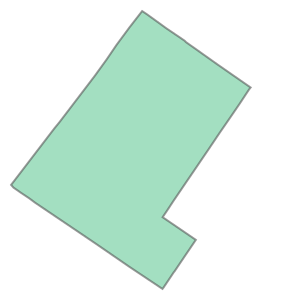

In [7]:
shape(geom)

### 3. Overlay the polygon on the raster

In [60]:
for idx, feat in enumerate(layer):
    print("you are reaching idx", idx)
    props = feat['properties']
    geom = feat['geometry']
    shape = [geom] # the rasterio need the list, therefore, create a list
    
    # mask the raster using the polygon
    out_lu_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
    
    # if idx > 10: break
    

#### In the land use encoding, the 1 encodes tree canopy, 2 encodes grass, 5 encodes buildings

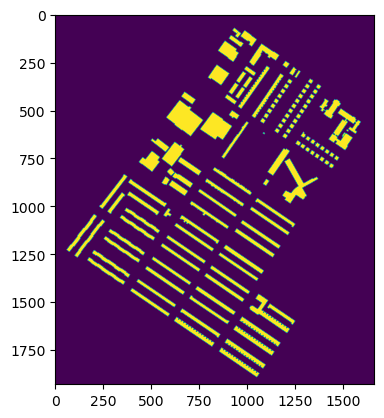

In [18]:
from matplotlib import pyplot as plt

plt.imshow(out_lu_image[0,:,:]==5)

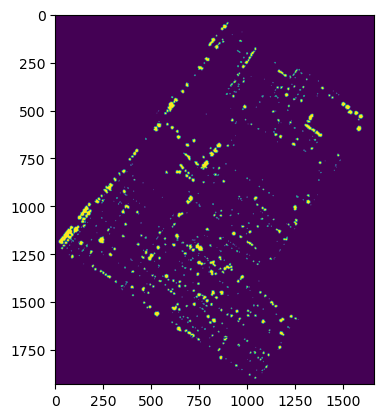

In [19]:
from matplotlib import pyplot as plt

plt.imshow(out_lu_image[0,:,:]==1)

#### We can calculate the tree canopy cover

In [30]:
# total number of 1 pixels
tree_pxls = np.sum(out_lu_image[0,:,:]==1)

# the total number of pixel for this polygon
total_pxls = np.sum(out_lu_image[0, :, :] != 255)

vegcover = tree_pxls/total_pxls*100 #the percentage of tree cover
vegcover

4.786693785822099

### 4. Zonal statistics overlay vector on raster image

We are going to overlay of the census tract data on the raster land use map. Therefore, we can calculate the percentage of the tree canopy cover map at the census tract level. 

In [61]:
output_shp_res = 'tree-canopy-cover.shp'
schema = layer.schema.copy()
schema['properties']['treecover'] = 'float'

with fiona.open(output_shp_res, 'w', driver = "ESRI Shapefile", crs = layer.crs, schema=schema) as output:
    for idx, feat in enumerate(layer):
        print('you are reaching:', idx)
        props = feat['properties']
        geom = feat['geometry']
        shape = [geom] # the rasterio need the list, therefore, create a list
        
        # mask the raster using the polygon
        out_lu_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
        
        # total number of 1 pixels
        tree_pxls = np.sum(out_lu_image[0,:,:]==1)
        
        # the total number of pixel for this polygon
        total_pxls = np.sum(out_lu_image[0, :, :] != 255)
        
        vegcover = tree_pxls/total_pxls*100 #the percentage of tree cover
        
        # update the calculate ndvi value to the field
        props['treecover'] = vegcover
        output.write({'properties': props,
                      'geometry': geom
                     })
        

### 5. Conduct the socio-environmental analysis
We have the shapefile created. It is easier to use GeoPandas to conduct the socio-environmental analysi. 

In [37]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

output_shp_res = 'tree-canopy-cover.shp'

df = gpd.read_file(output_shp_res)

In [38]:
df.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,fema_67_69,fema70_74,fema75_79,fema80_84,fema85_,state,county,tract,treecover,geometry
0,42,101,014500,42101014500,145,Census Tract 145,G5020,S,321465,0,...,46,33,7,17,28,42,101,014500,8.073224,"POLYGON ((2696627.315 244448.120, 2696698.907 ..."
1,42,101,031200,42101031200,312,Census Tract 312,G5020,S,429735,0,...,63,202,48,0,11,42,101,031200,8.264088,"POLYGON ((2714890.709 265894.603, 2714931.049 ..."
2,42,101,021800,42101021800,218,Census Tract 218,G5020,S,1006008,0,...,84,55,98,27,17,42,101,021800,29.965782,"POLYGON ((2671526.636 274669.516, 2672033.151 ..."
3,42,101,009100,42101009100,91,Census Tract 91,G5020,S,425574,0,...,33,131,42,42,53,42,101,009100,14.903659,"POLYGON ((2682586.599 239186.067, 2682814.771 ..."
4,42,101,033600,42101033600,336,Census Tract 336,G5020,S,1153477,0,...,86,80,28,72,48,42,101,033600,12.415315,"POLYGON ((2719080.860 276412.719, 2719388.820 ..."


In [39]:
df.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'NAME_y', 'GEO_ID', 'white_popu', 'non-hispan', 'black_popu',
       'asian_popu', 'hispanic_p', 'total_popu', 'median_hou', 'per_capita',
       'built_age', 'less_highs', 'bachelor', 'totaleduca', 'male_und18',
       'female_und', 'male65_66', 'male67_69', 'male70_74', 'male75_79',
       'male80_84', 'male85_', 'fema_65_66', 'fema_67_69', 'fema70_74',
       'fema75_79', 'fema80_84', 'fema85_', 'state', 'county', 'tract',
       'treecover', 'geometry'],
      dtype='object')

In [40]:

vegshp = 'tree-canopy-cover.shp'
vegdf = gpd.read_file(vegshp)

# calculate the values of different socio-economic variables
vegdf['income'] = pd.to_numeric(vegdf['per_capita'])/1000
# mrtdf['houseIncome'] = pd.to_numeric(mrtdf['median_hou'])

vegdf['perHis'] = pd.to_numeric(vegdf['hispanic_p'])/pd.to_numeric(vegdf['total_popu'])
vegdf['nonHispan'] = pd.to_numeric(vegdf['non-hispan'])/pd.to_numeric(vegdf['total_popu'])
vegdf['black'] = pd.to_numeric(vegdf['black_popu'])/pd.to_numeric(vegdf['total_popu'])
vegdf['asian'] = pd.to_numeric(vegdf['asian_popu'])/pd.to_numeric(vegdf['total_popu'])
vegdf['und18'] = (pd.to_numeric(vegdf['male_und18']) + pd.to_numeric(vegdf['female_und']))/pd.to_numeric(vegdf['total_popu'])
vegdf['highschol'] = pd.to_numeric(vegdf['less_highs'])/pd.to_numeric(vegdf['total_popu'])
vegdf['bachelor'] = pd.to_numeric(vegdf['bachelor'])/pd.to_numeric(vegdf['total_popu'])

vegdf['old65'] = (pd.to_numeric(vegdf['male65_66']) + \
                  pd.to_numeric(vegdf['male67_69']) + \
                  pd.to_numeric(vegdf['male70_74']) + \
                  pd.to_numeric(vegdf['male75_79']) + \
                  pd.to_numeric(vegdf['male80_84']) + \
                  pd.to_numeric(vegdf['male85_']) + \
                  pd.to_numeric(vegdf['fema_65_66']) + \
                  pd.to_numeric(vegdf['fema_67_69']) + \
                  pd.to_numeric(vegdf['fema70_74']) + \
                  pd.to_numeric(vegdf['fema75_79']) + \
                  pd.to_numeric(vegdf['fema80_84']) + \
                  pd.to_numeric(vegdf['fema85_'])) \
                  /pd.to_numeric(vegdf['total_popu'])


In [41]:
vegdf['income']

0      16.495
1      18.531
2      32.183
3      26.835
4      23.496
        ...  
379    28.052
380    13.556
381    98.619
382    16.646
383    18.873
Name: income, Length: 384, dtype: float64

In [43]:
vegdf['treecover']

0       8.073224
1       8.264088
2      29.965782
3      14.903659
4      12.415315
         ...    
379    20.588155
380     6.540126
381    23.792479
382    14.405313
383     4.786694
Name: treecover, Length: 384, dtype: float64

##### Calculate the correlation coefficient

In [44]:
#build the plot
import seaborn as sns
from scipy.stats.stats import pearsonr

pearsonr(vegdf['income'], vegdf['treecover'])


/var/folders/1j/rxctbd0d60l078ctybj6ktrr673nl9/T/ipykernel_71629/2001258105.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.020743342247260297, pvalue=0.6853281115765543)

You may find this is different from common sense. Let further plot the scatter plot and see if there is any problem. 

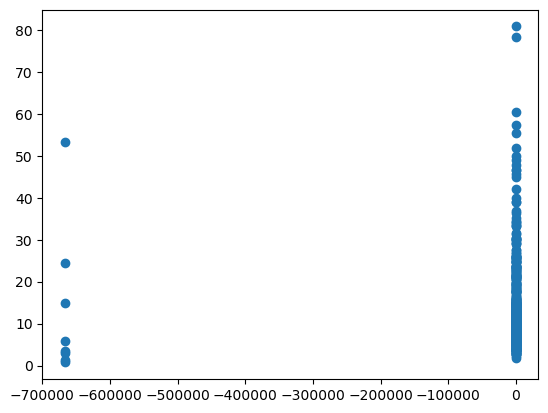

In [45]:
plt.scatter(vegdf['income'], vegdf['treecover'])

There are some abnormal records. We can check the minimum value of the income. 

In [46]:
vegdf['income'].min()

-666666.666

This is because some census tracts have no income data, and set as null -666666.666. We can drop those records. 

In [47]:
vegdf_valid = vegdf[vegdf['income'] > 0]


In [48]:
vegdf_valid['income'].min()

5.514

In [49]:
pearsonr(vegdf_valid['income'], vegdf_valid['treecover'])


PearsonRResult(statistic=0.21659317904721898, pvalue=2.2722662202124753e-05)

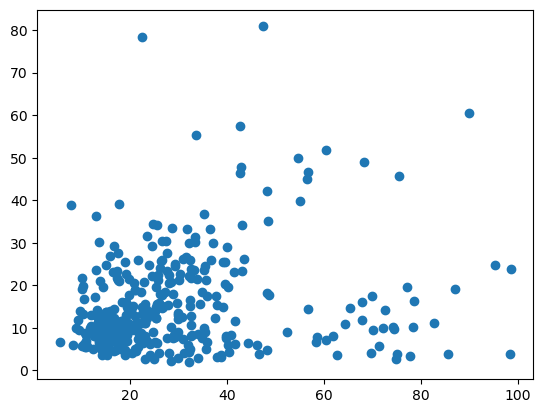

In [50]:
plt.scatter(vegdf_valid['income'], vegdf_valid['treecover'])

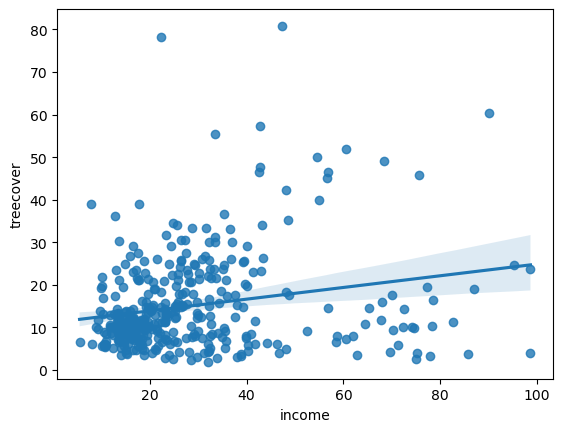

In [51]:
plot = sns.regplot(data=vegdf_valid, x="income", y="treecover")

We can estimate the correlation coefficient metrix of all variables

In [52]:
vegdf_valid2 = vegdf_valid.drop(columns=['ALAND', 'AWATER'])
vegdf_valid2.corr()


/var/folders/1j/rxctbd0d60l078ctybj6ktrr673nl9/T/ipykernel_71629/1431320366.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  vegdf_valid2.corr()


,bachelor,treecover,income,perHis,nonHispan,black,asian,und18,highschol,old65
bachelor,1.000000,0.195763,0.873035,-0.331214,0.654567,-0.510129,0.236205,-0.667244,-0.575064,0.252973
treecover,0.195763,1.000000,0.216593,-0.229432,0.226108,-0.078759,-0.111479,-0.166435,-0.348920,0.443010
income,0.873035,0.216593,1.000000,-0.306151,0.665329,-0.494144,0.100490,-0.584707,-0.595648,0.316897
perHis,-0.331214,-0.229432,-0.306151,1.000000,-0.217932,-0.252085,-0.031125,0.422030,0.610071,-0.350514
nonHispan,0.654567,0.226108,0.665329,-0.217932,1.000000,-0.851676,0.174924,-0.510471,-0.503530,0.254343
black,-0.510129,-0.078759,-0.494144,-0.252085,-0.851676,1.000000,-0.409225,0.349540,0.163000,-0.039428
asian,0.236205,-0.111479,0.100490,-0.031125,0.174924,-0.409225,1.000000,-0.282633,0.075223,-0.090803
und18,-0.667244,-0.166435,-0.584707,0.422030,-0.510471,0.349540,-0.282633,1.000000,0.478561,-0.304627
highschol,-0.575064,-0.348920,-0.595648,0.610071,-0.503530,0.163000,0.075223,0.478561,1.000000,-0.170341
old65,0.252973,0.443010,0.316897,-0.350514,0.254343,-0.039428,-0.090803,-0.304627,-0.170341,1.000000


### Regression analysis of the vegetation canopy cover and different socio-economic variables. 

In [53]:
# !pip install statsmodels

In [54]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import HTML, display


# again, invoke statsmodel's formula API using the below syntax
veg_model = ols("""treecover ~ income 
                            + perHis
                            + old65
                            + highschol
                            + und18""", data=vegdf_valid2).fit()

# summarize our model
veg_model_summary = veg_model.summary()
HTML(veg_model_summary.as_html())